Thanks to Tim and others for the basics of this Jupyter notebook

see also https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf

and https://gist.github.com/tamlyn/a9d2b3990f9dab0f82d1dfc1588c876a


# Implementing Policy Gradients on CartPole with PyTorch

In [1]:
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
%matplotlib inline

In [11]:
env = gym.make('CartPole-v1')
#env = gym.make('MountainCar-v0')
env.seed(1)
_ = torch.manual_seed(1) #suppress stdout

## Policy Gradients
A policy gradient attempts to train an agent without explicitly mapping the value for every state-action pair in an environment by taking small steps and updating the policy based on the reward associated with that step. The agent can receive a reward immediately for an action or the agent can receive the award at a later time such as the end of the episode. 
We’ll designate the policy function our agent is trying to learn as $\pi_\theta(a,s)$, where $\theta$ is the parameter vector, $s$ is a particular state, and $a$ is an action.

We'll apply a technique called Monte-Carlo Policy Gradient which means we will have the agent run through an entire episode and then update our policy based on the rewards obtained.

## Model Construction
### Create Neural Network Model
We will use a simple feed forward neural network with one hidden layer of 128 neurons and a dropout of 0.6.  We'll use Adam as our optimizer and a learning rate of 0.01.  Using dropout will significantly improve the performance of our policy.  I encourage you to compare results with and without dropout and experiment with other hyper-parameter values.

In [3]:
#Hyperparameters
learning_rate = 1e-2
gamma = 0.99

In [4]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        state_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        num_hidden = 128

        self.l1 = nn.Linear(state_space, num_hidden, bias=False)
        self.dropout = nn.Dropout(0.5)
        self.l2 = nn.Linear(num_hidden, action_space, bias=False)

        self.reward_history = []
        self.reset()

    def reset(self):
        self.episode_actions = torch.Tensor([])
        self.episode_rewards = []

    def forward(self, x):
        x = F.relu(self.dropout(self.l1(x)))
        x = F.softmax(self.l2(x), dim=-1)
        return x 

### Select Action
The select_action function chooses an action based on our policy probability distribution using the PyTorch distributions package.  Our policy returns a probability for each possible action in our action space (move left or move right) as an array of length two such as [0.7, 0.3].  We then choose an action based on these probabilities, record our history, and return our action. 

In [5]:
def predict(state):
    state = torch.from_numpy(state).type(torch.FloatTensor)
    
    action_probs = policy(state)    
    distribution = torch.distributions.Categorical(action_probs)
    action = distribution.sample()

    # Add log probability of our chosen action to our history
    policy.episode_actions = torch.cat([policy.episode_actions, distribution.log_prob(action).reshape(1)])

    return action

### Reward $v_t$
We update our policy by taking a sample of the action value function $Q^{\pi_\theta} (s_t,a_t)$ by playing through episodes of the game.  $Q^{\pi_\theta} (s_t,a_t)$ is defined as the expected return by taking action $a$ in state $s$ following policy $\pi$.

We know that for every step the simulation continues we receive a reward of 1.  We can use this to calculate the policy gradient at each time step, where $r$ is the reward for a particular state-action pair.  Rather than using the instantaneous reward, $r$, we instead use a long term reward $ v_{t} $ where $v_t$ is the discounted sum of all future rewards for the length of the episode.  In this way, the **longer** the episode runs into the future, the **greater** the reward for a particular state-action pair in the present. $v_{t}$ is then,

$$ v_{t} = \sum_{k=0}^{N} \gamma^{k}r_{t+k} $$

where $\gamma$ is the discount factor (0.99).  For example, if an episode lasts 5 steps, the reward for each step will be [4.90, 3.94, 2.97, 1.99, 1].
Next we scale our reward vector by substracting the mean from each element and scaling to unit variance by dividing by the standard deviation.  This practice is common for machine learning applications and the same operation as Scikit Learn's __[StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)__.  It also has the effect of compensating for future uncertainty.

## Update Policy
After each episode we apply Monte-Carlo Policy Gradient to improve our policy according to the equation:

$$\Delta\theta_t = \alpha\nabla_\theta \, \log \pi_\theta (s_t,a_t)v_t  $$

We will then feed our policy history multiplied by our rewards to our optimizer and update the weights of our neural network using stochastic gradent *ascent*.  This should increase the likelihood of actions that got our agent a larger reward.



In [6]:
def update_policy():
    R = 0
    rewards = []

    # backtracking rewards-to-go and calculate returns
    for r in policy.episode_rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)

    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    # Calculate loss
    loss = (torch.sum(torch.mul(policy.episode_actions, rewards).mul(-1), -1))

    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save and intialize episode history counters
    policy.reward_history.append(np.sum(policy.episode_rewards))
    policy.reset()

### Training
This is our main policy training loop.  For each step in a training episode, we choose an action, take a step through the environment, and record the resulting new state and reward.  We call update_policy() at the end of each episode to feed the episode history to our neural network and improve our policy.

In [7]:
def train(episodes):
    episode_rewards = []
    for episode in range(episodes):
        state = env.reset()
        for time in range(1000):
            action = predict(state)
            state, reward, done, _ = env.step(action.item())
            policy.episode_rewards.append(reward)
            if done:
                break
        episode_rewards.append(np.sum(policy.episode_rewards))

        mean_episode_reward = np.mean(episode_rewards[-100:])
        if episode % 50 == 0:
            print(episode, "episodes finished (with average sum of rewards: {:.2f})".format(mean_episode_reward))
        if mean_episode_reward > env.spec.reward_threshold:
            print("===============================")
            print("Solved after", episode, "episodes.")
            print("Running average:", mean_episode_reward)
            break
            
        update_policy()

## Run Model

In [12]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
train(episodes=500)

0 episodes finished (with average sum of rewards: 20.00)
50 episodes finished (with average sum of rewards: 51.00)
100 episodes finished (with average sum of rewards: 112.88)
150 episodes finished (with average sum of rewards: 185.70)
200 episodes finished (with average sum of rewards: 290.96)
250 episodes finished (with average sum of rewards: 364.43)
300 episodes finished (with average sum of rewards: 229.42)
350 episodes finished (with average sum of rewards: 114.04)
400 episodes finished (with average sum of rewards: 216.61)
450 episodes finished (with average sum of rewards: 409.89)
Solved after 473 episodes.
Running average: 477.71


Usually, the policy solves the environment prior to reaching 600 episodes for Cartpole-v1 (473 episodes with an average of 477.71) and around 300 episodes for Cartpole-v0 (298 episodes with an average of 195.81).

For the requirements of the environment see also how they get registered in gym:

```
register(
    id='CartPole-v0',
    entry_point='gym.envs.classic_control:CartPoleEnv',
    max_episode_steps=200,
    reward_threshold=195.0,
)

register(
    id='CartPole-v1',
    entry_point='gym.envs.classic_control:CartPoleEnv',
    max_episode_steps=500,
    reward_threshold=475.0,
)
```

### Plot Results

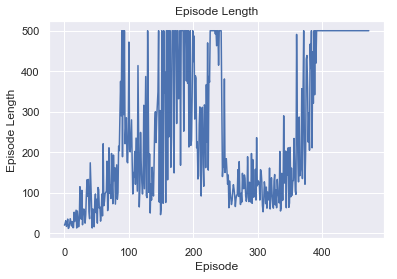

In [13]:
sns.set(style="darkgrid")
ax = sns.lineplot(style="event", hue="event", data=pd.Series(policy.reward_history), dashes=False, ci="sd")
ax.set_title('Episode Length')
ax.set_xlabel('Episode')
ax.set_ylabel('Episode Length')
plt.show()

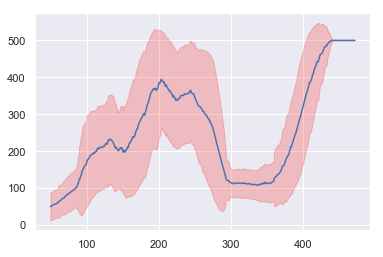

In [14]:
mean = pd.Series(policy.reward_history).rolling(50).mean()
std = pd.Series(policy.reward_history).rolling(50).std()

sns.set(style="darkgrid")
ax = sns.lineplot(style="event", hue="event", data=mean, dashes=False, ci="sd")
ax.fill_between(range(len(policy.reward_history)), mean-std, mean+std, color='red', alpha=0.2)
plt.show()